# Predicting Stock Prices from Expected Earnings
## 1. Overview

This project uses a Long Short-Term Memory (LSTM) network implemented in TensorFlow to predict stock prices. It takes as input the daily historical stock prices for a given stock, converts the data to windows, and outputs predicted stock prices for the length of the window.
## 2. Collecting and Cleaning Data
Data will be taken from the last 8 years' historical stock prices. It is housed in stocks_latest, which you can download on your own at <a href="https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data">this link</a>.

First, let's import the packages we'll be using.

In [47]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import seaborn as sns
import tensorflow as tf
from tensorflow.python.client import device_lib
from IPython.display import display, clear_output
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Make sure we're running tensorflow on GPU (if applicable):

In [48]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


Next, we'll extract our data as pandas dataframes.

In [49]:
stocks_data_path = "./datasets/stock_prices_latest.csv"

stocks_df_init = pd.read_csv(stocks_data_path)

Let's see what data our stocks file contains:

In [50]:
stocks_df = stocks_df_init.copy()
stocks_df.head()

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,2016-05-16,50.80,51.96,50.75,51.83,49.7013,20032017,1.0
1,MSFT,2002-01-16,68.85,69.84,67.85,67.87,22.5902,30977700,1.0
2,MSFT,2001-09-18,53.41,55.00,53.17,54.32,18.0802,41591300,1.0
3,MSFT,2007-10-26,36.01,36.03,34.56,35.03,27.2232,288121200,1.0
4,MSFT,2014-06-27,41.61,42.29,41.51,42.25,38.6773,74640000,1.0


We'll do the following to clean up the stocks dataset:
1. Remove split_coefficient, close, open, high, and low columns
2. Remove all data from before 2015
3. Convert our dates to seconds
4. Rename "close_adjusted" to "close"
5. Sort data by symbol, then by date

In [51]:
#Remove split_coefficient and close
stocks_df.drop(['split_coefficient','close', 'open', 'high', 'low'], axis=1, errors='ignore', inplace=True)

#Remove stock data from before 2015
stocks_df['date'] = pd.to_datetime(stocks_df.date)
stocks_df = stocks_df[(stocks_df['date'].dt.year >= 2015)]

#Convert dates to seconds
stocks_df['date'] = stocks_df['date'].map(datetime.datetime.timestamp)
stocks_df.rename(columns={'date':'time_seconds'}, inplace=True)

#Rename 'close_adjusted' to 'close'
stocks_df.rename(columns={'close_adjusted':'close'}, inplace=True)
                                                                                                          
#Sort data by symbol, then date
stocks_df.sort_values(by=['symbol','time_seconds'], inplace=True)

stocks_df.head()

,symbol,time_seconds,close,volume
8237673,A,1.420178e+09,39.3484,1530798
8236049,A,1.420438e+09,38.6111,2042240
8234683,A,1.420524e+09,38.0096,2084562
8237067,A,1.420610e+09,38.5141,3359660
8238420,A,1.420697e+09,39.6686,2116341


We'll be feeding our NN the stock data for individual stocks. First, we'll group the stock data by symbol and store in a dict of DataFrames.

In [52]:
stocks_sep = dict(tuple(stocks_df.groupby('symbol')))
symbol1 = stocks_sep['ZM']

## 3. Choosing Focus Stock

Let's choose a particular stock to focus on. In this example, I choose Apple (with ticker "AAPL"). We drop the 'symbol' and 'time_seconds' columns as they are no longer relevant to the neural network (the data is already ordered by date). Feel free to change the focus stock ticker and run the cells afterwards to make different stock predictions.

In [89]:
focus_stock = 'AAPL'
focus_stock_df = stocks_sep[focus_stock]
focus_stock_df.drop(['symbol', 'time_seconds'], axis=1, errors='ignore', inplace=True)
focus_stock_df.head()

,close,volume
7162,0.037118,0.158320
4827,0.030145,0.191701
7200,0.030168,0.196254
7351,0.033541,0.118862
8618,0.042914,0.176877


## 4. Normalization

We'd like to use both the closing price and the volume as inputs to our neural net. However, the large size of the volume compared to the closing price will bias the NN, so we normalize our data and force it into the range [0,1].

In [90]:
def normalize_column(df, column_name):
    x = df[column_name]
    min = x.min()
    max = x.max()
    return (x - min) / (max - min)

focus_stock_df['close'] = normalize_column(focus_stock_df, 'close')
focus_stock_df['volume'] = normalize_column(focus_stock_df, 'volume')
focus_stock_df.head()

,close,volume
7162,0.037118,0.158320
4827,0.030145,0.191701
7200,0.030168,0.196254
7351,0.033541,0.118862
8618,0.042914,0.176877


## 5. Splitting Data into Train/Val/Test Sets

Next we'll separate our data into training (80%) and test (20%) sets. We'll further separate the training set into training (64%) and validation (16%) sets (ie, an 80/20 split over the training set).

In [91]:
def get_breakpoint(n, percent):
    return int(np.floor(n * percent))

n = len(focus_stock_df)
breakpoint_1 = get_breakpoint(n, 0.64)
breakpoint_2 = get_breakpoint(n, 0.8)

train_df = focus_stock_df[:breakpoint_1]
val_df = focus_stock_df[breakpoint_1:breakpoint_2]
test_df = focus_stock_df[breakpoint_2:]

## 6. Generating Data Windows

We would like to feed our neural network "windows" of time series data to train on. A window is comprised of some number of input points and an output point. To do this, we create a WindowGenerator class, as suggested <a href="https://www.tensorflow.org/tutorials/structured_data/time_series">here</a>. We also define a split_window method to split a window into input and output, a plot method to aid in visualization, and a make_dataset method to convert a DataFrame into a tf.data.Dataset.

In [114]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
        self.train = self.make_dataset(self.train_df)
        self.val = self.make_dataset(self.val_df)
        self.test = self.make_dataset(self.test_df)
        
        self.example = self.example()

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='close', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
                
        plt.xlabel('Time [h]')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)
        return ds
    
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

## 7. Constructing and Fitting the NN Model
We'll now construct and compile our neural network model using LSTM layers. Parameters to experiment with include number of neurons per LSTM layer, number of LSTM layers, dropout percentage, addition of dense layers after the dropout layer, and the learning rate of our Adam optimizer.

In [164]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation=tf.nn.relu)
])

loss = tf.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
metrics = tf.metrics.MeanAbsoluteError()

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

Now we create our windows based on an arbitrary window size. The width can be changed to study its effect on the model. Here, a width of 30 was chosen to represent one month of stock data.

In [165]:
WIDTH = 30

window = WindowGenerator(
    input_width=WIDTH, label_width=WIDTH, shift=1,
    label_columns=['close'])

Finally, we fit the model to our windowed data. Again, the number of epochs can be tweaked. We set an early stopping callback to stop the fitting process if our error stops decreasing.

In [166]:
EPOCHS = 50

# Stop when MAE is no longer decreasing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.fit(window.train, epochs=EPOCHS,
            validation_data=window.val,
            callbacks=[early_stopping])

Epoch 1/50
29/29 [==============================] - 1s 50ms/step - loss: 0.0279 - mean_absolute_error: 0.1085 - val_loss: 0.0108 - val_mean_absolute_error: 0.0877
Epoch 2/50
29/29 [==============================] - 1s 28ms/step - loss: 0.0021 - mean_absolute_error: 0.0306 - val_loss: 0.0038 - val_mean_absolute_error: 0.0329
Epoch 3/50
29/29 [==============================] - 1s 28ms/step - loss: 0.0011 - mean_absolute_error: 0.0202 - val_loss: 0.0023 - val_mean_absolute_error: 0.0255
Epoch 4/50
29/29 [==============================] - 1s 28ms/step - loss: 6.7260e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0014 - val_mean_absolute_error: 0.0205
Epoch 5/50
29/29 [==============================] - 1s 28ms/step - loss: 4.6177e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0011 - val_mean_absolute_error: 0.0179
Epoch 6/50
29/29 [==============================] - 1s 29ms/step - loss: 3.4951e-04 - mean_absolute_error: 0.0114 - val_loss: 8.0269e-04 - val_mean_absolute_error: 0.0157
Epoch 

## 8. Results and Conclusion

Our predictions are plotted below alongside the actual data. The predicted value at time `t = 30` turned out somewhat close to the actual value. Due to the volatile nature of stocks, this would not likely be the case in repeated experiments. However, the LSTM network does a reasonable job of following the overall trends of the stock.

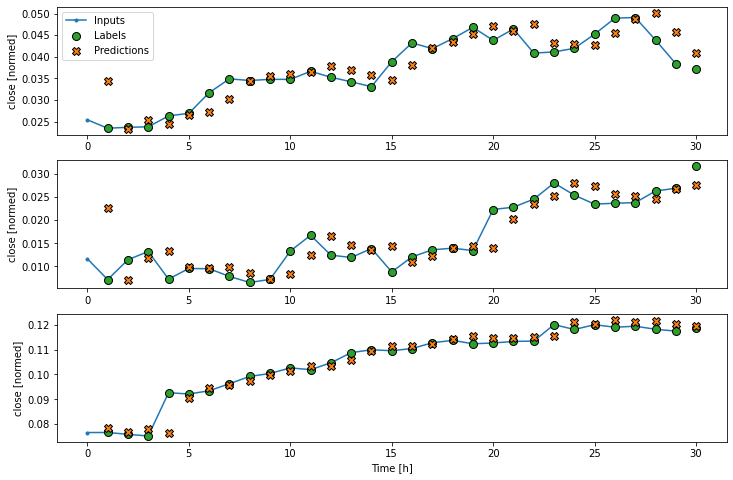

In [167]:
window.plot(model)

Future additions to this project could include:
1. Pulling data directly from Yahoo Finance to include more recent stock data
2. Optimizing hyperparameters for better model fit
3. First calculating moving averages of the windowed data before feeding to NN
4. Attempting autoregressive techniques, such as ARIMA, for predicting multiple future timesteps